## Import libraries

In [108]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer, CopulaGANSynthesizer
from sdmetrics.visualization import get_column_plot
from sdv.sampling import Condition
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

pd.set_option('display.max_columns', None)

## Data Loading

In [109]:
# File path to the Excel file
file_path = 'Dataset_2.0_Akkodis.xlsx'

# Import the dataset into a pandas DataFrame
original_data = pd.read_excel(file_path)

In [110]:
original_data.head()

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Candidate notification,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,NaN,RS18.0145,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Contact note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,OK,RS18.0114,~ 2 - Medium,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,2.0,2.0,1.0,2.0,2.0,3.0,3.0
4,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Commercial note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
original_data.shape

(21377, 39)

In [112]:
original_data.head()

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Candidate notification,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,NaN,RS18.0145,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Contact note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,OK,RS18.0114,~ 2 - Medium,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,2.0,2.0,1.0,2.0,2.0,3.0,3.0
4,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Commercial note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
original_data.describe(include='all')

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
count,21377.000000,21377,21377,21374,21377,85,10647,21332,21377,21377,12214,12214,21377,2389,2095,2382,2382,2382,19787,5846,6325,5984,2118,2091,2120,1169,1528,2120,2120,2120,4156,4119,5955.000000,5974.000000,5968.00000,5964.000000,5965.000000,5974.000000,5944.000000
unique,NaN,7,7,2507,2,2,2245,48,7,7,14,2698,6,7,359,18,7,19,13,15,1746,8,350,350,7,15,18,7,26,18,18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Imported,26 - 30 years,TURIN » Turin ~ Piedmont,Male,Article 1,.,Mechanical engineering,Five-year degree,[0],Others,Fresh graduate,[2022],[2022],Powertrain Calibration Engineer,Turin,Engineering,Consultant,CV request,OK,RS19.0367,~ 2 - Medium,"The resource, included in a team dedicated to ...",.,[1-3],24-26K,30-32K,Five-year degree,electronic Engineering,Turin,Not available,Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,7515,10080,3491,16722,76,633,3866,12522,12376,5357,736,8295,699,47,607,1498,860,8706,3597,72,3879,34,44,652,220,250,1454,337,557,1401,1650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,40519.752023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.177666,2.265149,2.32004,2.285714,2.296060,2.225979,2.764973
std,23615.657709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.620178,0.573715,0.59193,0.585352,0.588163,0.810831,0.540574
min,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
25%,20228.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,3.000000
50%,40413.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,3.000000
75%,61043.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000


In [114]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21377 entries, 0 to 21376
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        21377 non-null  int64  
 1    Candidate State          21377 non-null  object 
 2    Age Range                21377 non-null  object 
 3    Residence                21374 non-null  object 
 4    Sex                      21377 non-null  object 
 5    Protected category       85 non-null     object 
 6    TAG                      10647 non-null  object 
 7    Study area               21332 non-null  object 
 8    Study Title              21377 non-null  object 
 9    Years Experience         21377 non-null  object 
 10   Sector                   12214 non-null  object 
 11   Last Role                12214 non-null  object 
 12   Year of insertion        21377 non-null  object 
 13   Year of Recruitment      2389 non-null   object 
 14   Recru

In [115]:
original_data.nunique()

ID                          12263
 Candidate State                7
 Age Range                      7
 Residence                   2507
 Sex                            2
 Protected category             2
 TAG                         2245
 Study area                    48
 Study Title                    7
 Years Experience               7
 Sector                        14
 Last Role                   2698
 Year of insertion              6
 Year of Recruitment            7
 Recruitment Request          359
 Assumption Headquarters       18
 Job Family Hiring              7
 Job Title Hiring              19
 event_type__val               13
 event_feedback                15
 linked_search__key          1746
 Overall                        8
 Job Description              350
 Candidate Profile            350
 Years Experience.1             7
 Minimum Ral                   15
 Ral Maximum                   18
 Study Level                    7
 Study Area.1                  26
 Akkodis headq

## Data cleaning

In [116]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21377 entries, 0 to 21376
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        21377 non-null  int64  
 1    Candidate State          21377 non-null  object 
 2    Age Range                21377 non-null  object 
 3    Residence                21374 non-null  object 
 4    Sex                      21377 non-null  object 
 5    Protected category       85 non-null     object 
 6    TAG                      10647 non-null  object 
 7    Study area               21332 non-null  object 
 8    Study Title              21377 non-null  object 
 9    Years Experience         21377 non-null  object 
 10   Sector                   12214 non-null  object 
 11   Last Role                12214 non-null  object 
 12   Year of insertion        21377 non-null  object 
 13   Year of Recruitment      2389 non-null   object 
 14   Recru

In [117]:
for i in sorted(original_data[' Last Role'].unique(), key=str):
    print(i)

 Corse Powertrain Division
 Drone Contest
 Engineer
 Financial Advisor
 Internship and Thesis at University
 OPERATIONS ENGINEER
 Project Manager
 Researcher
 Simulation Manager for Galileo satellites & ground Operations
 System Engineer
 researchers & Data Scientists
-
.
.NET Developer
.NET Full Stack Developer
.NET Programmer Analyst
.NET developer
.NET programmer
/
3D Mechanical Designer
3D PIPING ENGINEER OIL, GAS & REFINING SECTOR
3rd level metalworker employee 
????
ADAS Algorithm Engineer
ADAS Developer
ADAS Engineer
ADAS Passive Safety
ADAS System Resident Engineer
ADAS Validation Engineer
ADAS development internal
ADMINISTRATIVE EMPLOYEE
ADMINISTRATIVE EMPLOYEE - PURCHASING OFFICE
ADMINISTRATIVE EMPLOYEE / GRAPHIC DESIGNER
AERODYNAMICS ENGINEER
AEROSPACE FUNCTIONAL TESTER
AI Software Engineer
AI mobile software engineer
AI&C System Completion Coordinator
AIRWORTHINESS ENGINEER
AIT Consultant
AIT/AIV Engineer
AO NPO Lavockina-Secretariat and Report
ASSOCIATE PROJECT MANAGER
AUT

In [118]:
data = original_data.copy()

def organize_data(data):
    data.columns = data.columns.str.strip()
    data = data.map(lambda x: x.strip() if isinstance(x, str) else x)

    # Drop duplicate rows
    data = data.drop_duplicates()

    # Drop the tilde in the 'Overall' column
    data['Overall'] = data['Overall'].str.lstrip('~ ')

    # Convert the columns 'Year of insertion' and 'Year of Recruitment' to integers
    data['Year of insertion'] = pd.to_numeric(data['Year of insertion'].str.strip('[]'), errors='coerce').astype('Int64')
    data['Year of Recruitment'] = pd.to_numeric(data['Year of Recruitment'].str.strip('[]'), errors='coerce').astype('Int64')
    
    undesired_values = ['????', '-', '.', '/']
    data.loc[data['Last Role'].isin(undesired_values), 'Last Role'] = np.nan

    # Group the same IDs in a unique row
    def group_ids(df):
        # Count non-NaN values in each row
        df['non_nan_count'] = df.notna().sum(axis=1)
        # Keep the row with the highest non-NaN count per ID
        df = df.loc[df.groupby('ID')['non_nan_count'].idxmax()] 
        # Drop helper column
        df = df.drop(columns=['non_nan_count'])
        return df
    
    data = group_ids(data)

    return data

data = organize_data(data)

In [119]:
data.head()

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
18731,15,Imported,26 - 30 years,SQUINZANO » Lecce ~ Puglia,Male,NaN,NaN,computer engineering,Three-year degree,[0],NaN,NaN,2023,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18733,36,Imported,20 - 25 years,ALESSANDRIA » Alessandria ~ Piedmont,Male,NaN,NaN,Aeronautical/Aerospace/Astronautics Engineering,Three-year degree,[0],NaN,NaN,2023,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17359,39,Imported,26 - 30 years,BARI » Bari ~ Puglia,Male,NaN,NaN,Automation/Mechatronics Engineering,Five-year degree,[0],NaN,NaN,2022,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6642,41,First contact,31 - 35 years,PERCH DOSIMO » Cremona ~ Lombardy,Male,NaN,NaN,industrial engineering,Five-year degree,[1-3],Others,Business Analyst Consultant,2021,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15905,47,First contact,36 - 40 years,GERMANY » (STATE) ~ (OVERSEAS),Male,NaN,NaN,Electrical Engineering,Five-year degree,[+10],Energy,ET Solutions AG,2022,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
data.shape

(12263, 39)

In [121]:
print(len(data['Recruitment Request'].unique()))
print(data['Recruitment Request'].isna().sum())
#print((data['Recruitment Request'].unique()))

354
11841


Colonne TAG e Last Role: riduce i possibili valori delle due colonne

In [122]:
print(len(data['Last Role'].unique()))
print(len(data['TAG'].unique()))

2572
2201


In [123]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
 
def preprocess_text(text):
    """Rimuove caratteri speciali e converte il testo in minuscolo."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Rimuove caratteri speciali
    return text.lower()
 
# Supponiamo che unique_last_roles e unique_tag siano liste estratte dai dati
unique_last_roles = data['Last Role'].dropna().unique().tolist()
unique_tag = data['TAG'].dropna().unique().tolist()
 
def cluster_and_map_roles(unique_values):
    processed_values = [preprocess_text(value) for value in unique_values]
 
    # Creazione della matrice TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(processed_values)
 
    # Clustering gerarchico
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5, linkage='ward')
    clusters = clustering.fit_predict(X.toarray())
 
    # Creazione del dizionario con i cluster
    value_clusters = {}
    for value, cluster_id in zip(unique_values, clusters):
        if cluster_id not in value_clusters:
            value_clusters[cluster_id] = []
        value_clusters[cluster_id].append(value)
 
    # Assegna un nome a ogni cluster basato sulle parole più comuni
    cluster_names = {}
    for cluster_id, values in value_clusters.items():
        words = []
        for value in values:
            words.extend(preprocess_text(value).split())
        common_words = [word for word, count in Counter(words).most_common(2)]
        cluster_names[cluster_id] = "-".join(common_words) if common_words else "Unknown"
 
    return clusters, cluster_names
 
# Clusterizzazione e assegnazione dei nomi per Last Role
clusters_last_roles, cluster_names_last_roles = cluster_and_map_roles(unique_last_roles)
clusters_tags, cluster_names_tags = cluster_and_map_roles(unique_tag)
 
def map_to_cluster_name(value, unique_values, clusters, cluster_names):
    if value in unique_values:
        cluster_id = clusters[unique_values.index(value)]
        return cluster_names.get(cluster_id, value)
    return value

In [124]:
data['Last Role'] = data['Last Role'].apply(lambda role: map_to_cluster_name(role, unique_last_roles, clusters_last_roles, cluster_names_last_roles))
data['TAG'] = data['TAG'].apply(lambda tag: map_to_cluster_name(tag, unique_tag, clusters_tags, cluster_names_tags))

In [125]:
print(len(data['Last Role'].unique()))
print(len(data['TAG'].unique()))

524
400


## Metadata

In [126]:
metadata = Metadata.detect_from_dataframe(data=data)

# Set column Candidate State to categorical
metadata.update_column(
    column_name='Candidate State',
    sdtype='categorical')

# Set column Last Role to categorical
metadata.update_column(
    column_name='Last Role',
    sdtype='categorical')

'''metadata.update_column( 
    column_name='Year of insertion',
    sdtype='numerical',
    computer_representation='Int64'
    )

metadata.update_column( 
    column_name='Year of Recruitment',
    sdtype='numerical',
    computer_representation='Int64'
    )'''

"metadata.update_column( \n    column_name='Year of insertion',\n    sdtype='numerical',\n    computer_representation='Int64'\n    )\n\nmetadata.update_column( \n    column_name='Year of Recruitment',\n    sdtype='numerical',\n    computer_representation='Int64'\n    )"

In [127]:
metadata

{
    "tables": {
        "table": {
            "primary_key": "ID",
            "columns": {
                "ID": {
                    "sdtype": "id"
                },
                "Candidate State": {
                    "sdtype": "categorical"
                },
                "Age Range": {
                    "sdtype": "categorical"
                },
                "Residence": {
                    "sdtype": "categorical"
                },
                "Sex": {
                    "sdtype": "categorical"
                },
                "Protected category": {
                    "sdtype": "categorical"
                },
                "TAG": {
                    "sdtype": "categorical"
                },
                "Study area": {
                    "sdtype": "categorical"
                },
                "Study Title": {
                    "sdtype": "categorical"
                },
                "Years Experience": {
                    "sdtype": "

In [128]:
metadata.validate()

## Synthesizer

In [129]:
synthesizer = GaussianCopulaSynthesizer(
    metadata,
    locales='it_IT',
#    verbose=True
)

synthesizer.auto_assign_transformers(data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



## Add Constraints

In [130]:
'''# load the constraint from the file
synthesizer.load_custom_constraint_classes(
    filepath='custom_constraint_years.py',
    class_names=['MyCustomConstraintClass']
)

year_constraint = {
    'constraint_class': 'MyCustomConstraintClass',
    'constraint_parameters': {
        'column_names': ['Candidate State', 'Year of insertion', 'Year of Recruitment']
    }
}'''

"# load the constraint from the file\nsynthesizer.load_custom_constraint_classes(\n    filepath='custom_constraint_years.py',\n    class_names=['MyCustomConstraintClass']\n)\n\nyear_constraint = {\n    'constraint_class': 'MyCustomConstraintClass',\n    'constraint_parameters': {\n        'column_names': ['Candidate State', 'Year of insertion', 'Year of Recruitment']\n    }\n}"

In [131]:
experience_age_constraint = {
    'constraint_class': 'FixedCombinations',
    'constraint_parameters': {
        'column_names': ['Age Range', 'Years Experience']
    }
}

recruitment_constraint = {
    'constraint_class': 'FixedCombinations',
    'constraint_parameters': {
        'column_names': ['Candidate State', 'Year of Recruitment']
    }
}

synthesizer.add_constraints(constraints=[
    experience_age_constraint,
    recruitment_constraint
    #year_constraint
])

## Fit synthesither and Sample data

In [132]:
synthesizer.fit(data)

synthetic_data = synthesizer.sample(num_rows=10000)

Sampling rows: 100%|██████████| 10000/10000 [00:00<00:00, 16067.43it/s]


In [133]:
'''synthesizer = CTGANSynthesizer(
    metadata,
    locales='it_IT',
    epochs=5
#    verbose=True
)

synthesizer.auto_assign_transformers(data)

synthesizer.fit(data)

synthetic_data = synthesizer.sample(num_rows=1000)'''

"synthesizer = CTGANSynthesizer(\n    metadata,\n    locales='it_IT',\n    epochs=5\n#    verbose=True\n)\n\nsynthesizer.auto_assign_transformers(data)\n\nsynthesizer.fit(data)\n\nsynthetic_data = synthesizer.sample(num_rows=1000)"

In [134]:
synthesizer.get_transformers()


{'ID': AnonymizedFaker(function_name='random_int', function_kwargs={'min': 0, 'max': 16777216}, cardinality_rule='unique'),
 'Residence': UniformEncoder(),
 'Sex': UniformEncoder(),
 'Protected category': UniformEncoder(),
 'TAG': UniformEncoder(),
 'Study area': UniformEncoder(),
 'Study Title': UniformEncoder(),
 'Sector': UniformEncoder(),
 'Last Role': UniformEncoder(),
 'Year of insertion': UniformEncoder(),
 'Recruitment Request': UniformEncoder(),
 'Assumption Headquarters': UniformEncoder(),
 'Job Family Hiring': UniformEncoder(),
 'Job Title Hiring': UniformEncoder(),
 'event_type__val': UniformEncoder(),
 'event_feedback': UniformEncoder(),
 'linked_search__key': UniformEncoder(),
 'Overall': UniformEncoder(),
 'Job Description': UniformEncoder(),
 'Candidate Profile': UniformEncoder(),
 'Years Experience.1': UniformEncoder(),
 'Minimum Ral': UniformEncoder(),
 'Ral Maximum': UniformEncoder(),
 'Study Level': UniformEncoder(),
 'Study Area.1': UniformEncoder(),
 'Akkodis head

In [135]:
synthetic_data.head(20)

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,8179297,First contact,< 20 years,ASCOLI PICENO » Ascoli-Piceno ~ Marche,Male,NaN,administration-management,electronic Engineering,Five-year degree,[0-1],Automotive,NaN,2021,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,RS22.1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24-26 K,NaN,NaN,2.0,NaN,NaN,NaN,3.0,3.0
1,7414570,Imported,31 - 35 years,ROME » Rome ~ Lazio,Male,NaN,NaN,Electrical Engineering,Three-year degree,[5-7],NaN,product-development,2023,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,390390,Imported,20 - 25 years,SWIMMING POOL » Turin ~ Piedmont,Male,NaN,NaN,computer engineering,Three-year degree,[0],NaN,NaN,2022,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10658106,First contact,26 - 30 years,TORTORETO » Teramo ~ Abruzzo,Male,NaN,materials-engineering,industrial engineering,Three-year degree,[0],NaN,NaN,2020,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,The ideal candidate is a recent graduate in Me...,NaN,NaN,26-28K,Five-year degree,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,3.0,3.0
4,10110043,First contact,< 20 years,PADERNO DUGNANO » Milan ~ Lombardy,Male,NaN,automotive-mechanical,Biomedical Engineering,Five-year degree,[0-1],Consulting,field-hse,2021,<NA>,NaN,NaN,NaN,NaN,Contact note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Valenzano,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,13862948,In selection,< 20 years,AVERSA » Caserta ~ Campania,Male,NaN,back-end,Energy and Nuclear Engineering,Five-year degree,[7-10],Space,cloud-migration,2023,<NA>,NaN,Gallarate,NaN,NaN,Research association,OK (live),RS21.0221,3 - High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,3.0,1.0,2.0,3.0
6,8301953,First contact,20 - 25 years,SAVIANO » Naples ~ Campania,Male,NaN,NaN,chemical engineering,Three-year degree,[0],NaN,NaN,2022,<NA>,NaN,NaN,NaN,NaN,Contact note,NaN,RS23.0803,3 - High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN
7,15234470,In selection,31 - 35 years,SAN SEVERO » Foggia ~ Puglia,Female,NaN,NaN,Informatics,High school graduation,[1-3],NaN,phd-student,2022,<NA>,Jr. Calibration Engineer,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,3.0,NaN,NaN,NaN,3.0
8,6162191,QM,26 - 30 years,PALO DEL COLLE » Bari ~ Puglia,Male,NaN,NaN,Mechanical engineering,Five-year degree,[1-3],Oil and Gas,vv-engineer,2022,<NA>,NaN,NaN,NaN,NaN,Contact note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
9,4334613,Imported,26 - 30 years,ROME » Rome ~ Lazio,Female,NaN,NaN,electronic Engineering,Five-year degree,[0],NaN,technical-manager,2022,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata,
    #column_names=['Year of insertion', 'Year of Recruitment'],
    column_names=['Candidate State', 'Year of Recruitment'],
    plot_type='box'
    )
    
fig.show()

In [137]:
# 1. perform basic validity checks
diagnostic_report = run_diagnostic(data, synthetic_data, metadata)

diagnostic_report.get_details(property_name='Data Validity')

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 39/39 [00:00<00:00, 892.29it/s]|
Data Validity Score: 97.54%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 875.64it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 98.77%



,Column,Metric,Score
0,ID,KeyUniqueness,1.0000
1,Candidate State,CategoryAdherence,1.0000
2,Age Range,CategoryAdherence,1.0000
3,Residence,CategoryAdherence,1.0000
4,Sex,CategoryAdherence,1.0000
5,Protected category,CategoryAdherence,1.0000
6,TAG,CategoryAdherence,1.0000
7,Study area,CategoryAdherence,1.0000
8,Study Title,CategoryAdherence,1.0000
9,Years Experience,CategoryAdherence,1.0000


In [143]:
# 2. measure the statistical similarity
quality_report = evaluate_quality(data, synthetic_data, metadata)

quality_report.get_details(property_name='Column Shapes')

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 39/39 [00:00<00:00, 352.70it/s]|
Column Shapes Score: 92.8%

(2/2) Evaluating Column Pair Trends: |██████████| 741/741 [00:03<00:00, 212.53it/s]|
Column Pair Trends Score: 89.76%

Overall Score (Average): 91.28%



,Column,Metric,Score
0,Candidate State,TVComplement,0.989782
1,Age Range,TVComplement,0.992907
2,Residence,TVComplement,0.860032
3,Sex,TVComplement,0.997412
4,Protected category,TVComplement,0.936364
5,TAG,TVComplement,0.876853
6,Study area,TVComplement,0.980155
7,Study Title,TVComplement,0.992767
8,Years Experience,TVComplement,0.993615
9,Sector,TVComplement,0.977723


In [146]:
quality_report.get_details(property_name='Column Pair Trends').head(20)

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,Candidate State,Age Range,ContingencySimilarity,0.852859,NaN,NaN
1,Candidate State,Residence,ContingencySimilarity,0.598122,NaN,NaN
2,Candidate State,Sex,ContingencySimilarity,0.980726,NaN,NaN
3,Candidate State,Protected category,ContingencySimilarity,0.985394,NaN,NaN
4,Candidate State,TAG,ContingencySimilarity,0.790366,NaN,NaN
5,Candidate State,Study area,ContingencySimilarity,0.818861,NaN,NaN
6,Candidate State,Study Title,ContingencySimilarity,0.907896,NaN,NaN
7,Candidate State,Years Experience,ContingencySimilarity,0.812923,NaN,NaN
8,Candidate State,Sector,ContingencySimilarity,0.738948,NaN,NaN
9,Candidate State,Last Role,ContingencySimilarity,0.676996,NaN,NaN


In [139]:
# 3. plot the data
columns_to_plot = ['Minimum Ral', 'Ral Maximum', 'Current Ral', 'Expected Ral', 'Year of insertion', 'Year of Recruitment', 'Sex', 'Candidate State', 'Age Range', 'Years Experience']
for col in columns_to_plot:
    fig = get_column_plot(
        real_data=data,
        synthetic_data=synthetic_data,
        metadata=metadata,
        column_name=col,
        plot_type='bar'
    )
        
    fig.show()

Number of instances with Sex = Male: 9435
Number of 'Not available' instances for Male: 542 (6.09%)


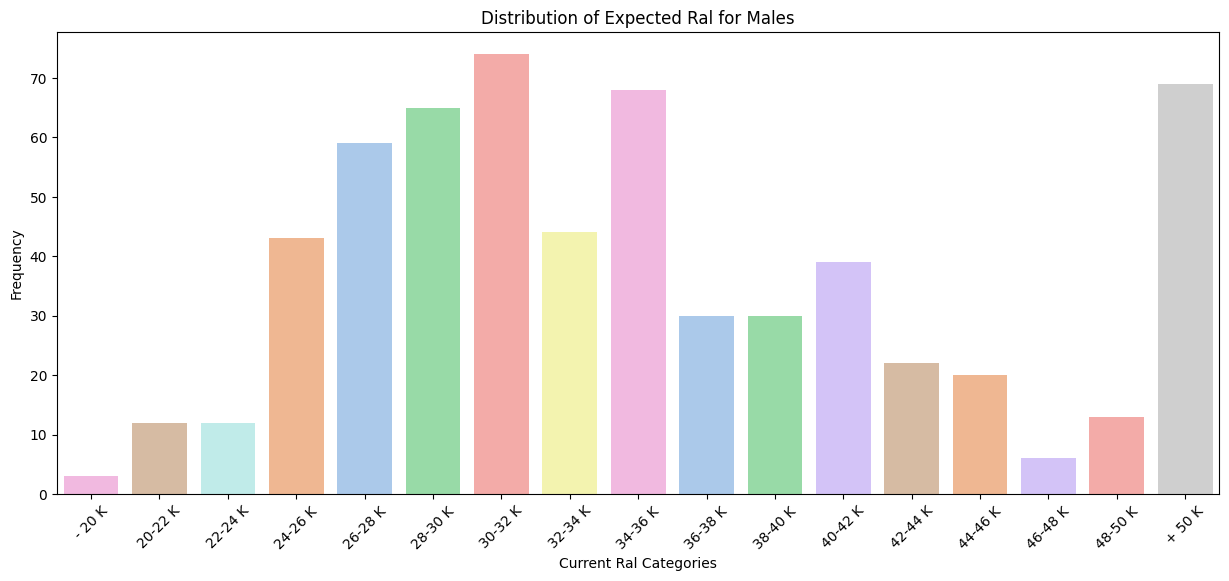

Number of instances with Sex = Female: 2828
Number of 'Not available' instances for Female: 145 (5.40%)


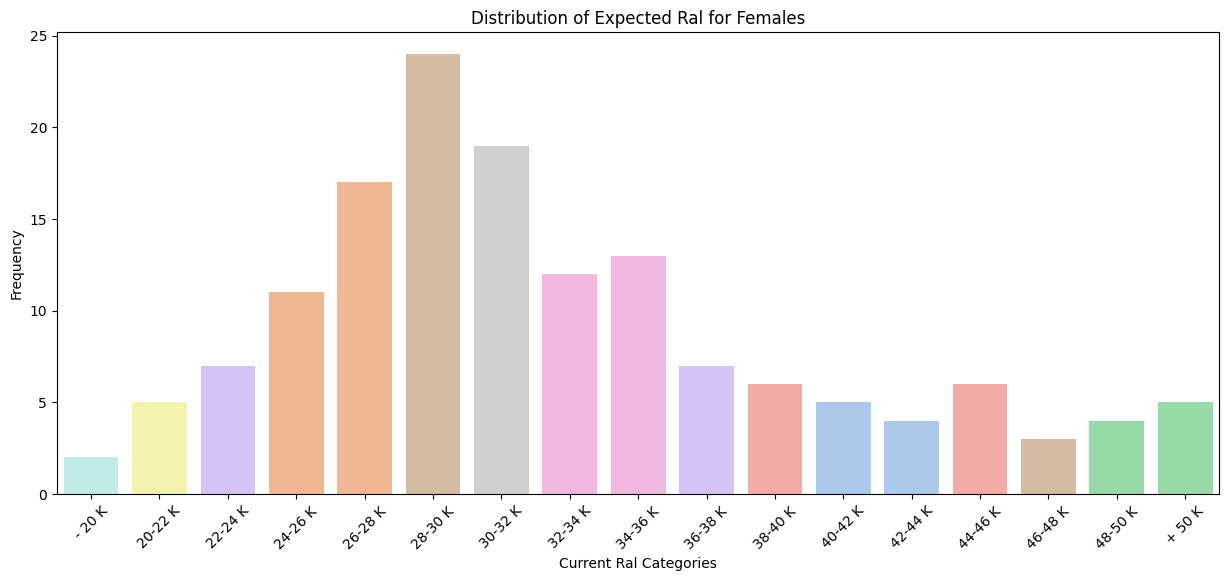

Number of instances with Sex = Male: 7668
Number of 'Not available' instances for Male: 448 (6.20%)


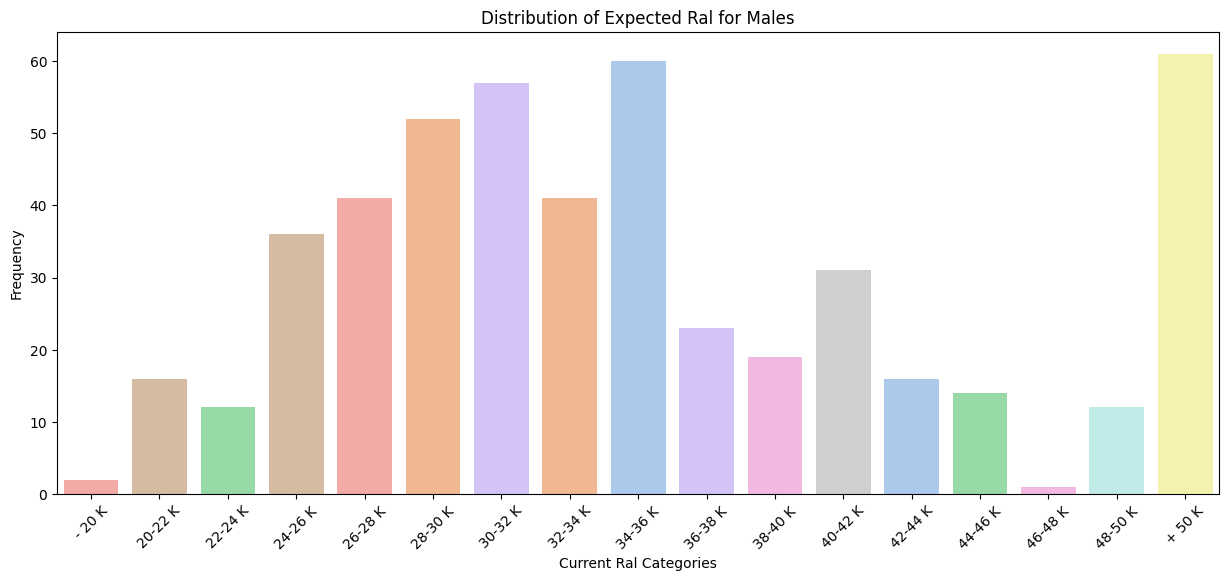

Number of instances with Sex = Female: 2332
Number of 'Not available' instances for Female: 124 (5.62%)


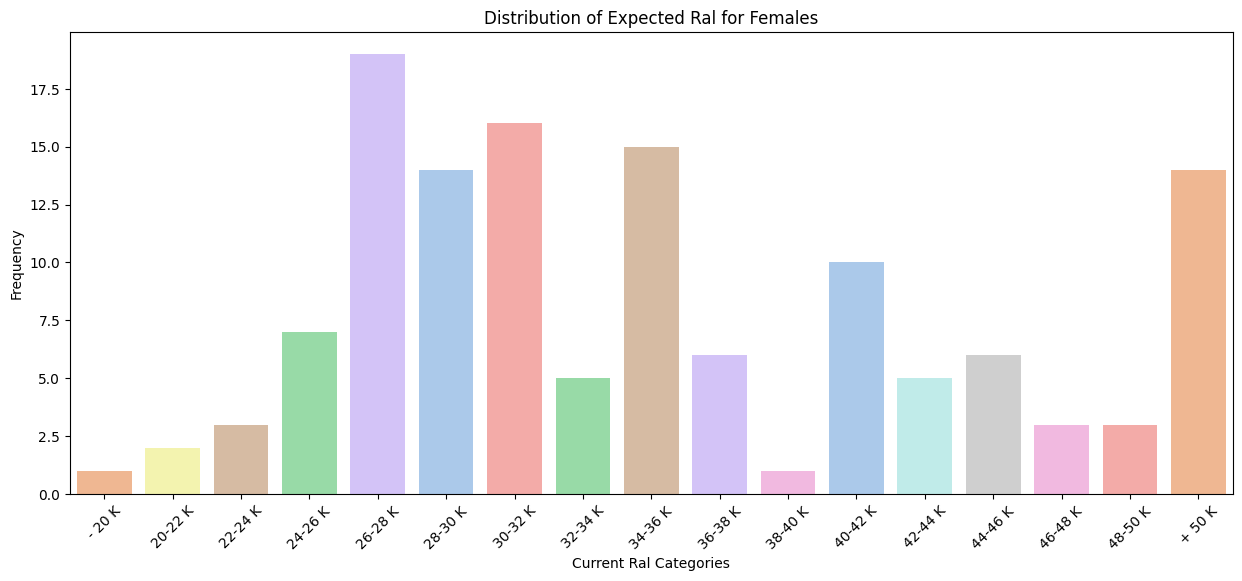

In [140]:
def plot_current_ral_distribution(data, sex):
    """
    Filters the DataFrame for rows where Sex matches the input sex and plots the distribution
    of the 'Current Ral' column, excluding 'Not available' values.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame containing at least the columns 'Sex' and 'Current Ral'.
    sex (str): The sex category to filter for ('Male' or 'Female')
    """
    

    ral_col = 'Expected Ral'

    
    # Print the number of instances with given sex
    print(f"Number of instances with Sex = {sex}: {len(data[data['Sex'] == sex])}")

    # Filter the DataFrame for specified sex and exclude 'Not available'
    filtered_data = data[(data['Sex'] == sex) & (data[ral_col] != 'Not available')]

    # Count and print 'Not available' instances
    not_available_count = len(data[(data['Sex'] == sex) & (data[ral_col] == 'Not available')])
    print(f"Number of 'Not available' instances for {sex}: {not_available_count} ({not_available_count / len(filtered_data) * 100:.2f}%)")

    # Convert range strings like '32-34k' into a numeric lower bound and sort the filtered data
    filtered_data = filtered_data.copy()
    filtered_data['Current_Ral_numeric'] = filtered_data[ral_col].str.extract(r'(\d+)-\d+k', expand=False).astype(float)
    filtered_data = filtered_data.sort_values('Current_Ral_numeric')

    def custom_sort_key(s):
        if isinstance(s, str):
            if s.strip()[0] == '-':
                return (-1, s)
        return (1, s)

    sorted_categories = natsorted(filtered_data[ral_col].dropna().unique(), key=custom_sort_key)
    plt.figure(figsize=(15, 6))
    sns.countplot(data=filtered_data, x=ral_col, order=sorted_categories, palette='pastel', hue=ral_col, legend=False)
    
    plt.xlabel("Current Ral Categories")

    plt.title(f"Distribution of {ral_col} for {sex}s")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
# Assuming 'synthetic_data' is your DataFrame:
plot_current_ral_distribution(data, 'Male')
plot_current_ral_distribution(data, 'Female')
plot_current_ral_distribution(synthetic_data, 'Male')
plot_current_ral_distribution(synthetic_data, 'Female')

## Polarization

Use the Condition class from sdv.sampling to make conditioned sampling.

In [141]:
# Define the condition for Sex column (e.g., only for 'Female')
condition_sex = Condition(
    num_rows=500,
    column_values={'Sex': 'Female'}
)

# Generate synthetic data using the condition on Sex
synthetic_data_conditioned = synthesizer.sample_from_conditions(
    conditions=[condition_sex]
)

# Preview the conditioned synthetic data
synthetic_data_conditioned.head(20)

Sampling conditions: 100%|██████████| 500/500 [00:00<00:00, 4219.83it/s]


,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,8424683,In selection,31 - 35 years,LIGURIAN CELLS » Savona ~ Liguria,Female,NaN,NaN,Mechanical engineering,High school graduation,[0],NaN,environmental-engineer,2022,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,RS23.0393,2 - Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40-42 K,1.0,2.0,2.0,2.0,2.0,NaN,NaN
1,1920737,Imported,20 - 25 years,QUATTORDIO » Alessandria ~ Piedmont,Female,NaN,ansys-fluent,computer engineering,Three-year degree,[0],NaN,NaN,2022,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,RS23.1500,NaN,Test Plan Manager activities. Vehicle project ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36-38 K,2.0,2.0,2.0,2.0,2.0,NaN,3.0
2,14522355,First contact,26 - 30 years,ALTAMURA » Bari ~ Puglia,Female,NaN,NaN,computer engineering,Three-year degree,[0-1],NaN,NaN,2023,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9876017,In selection,26 - 30 years,MILAN » Milan ~ Lombardy,Female,NaN,NaN,Automation/Mechatronics Engineering,Five-year degree,[3-5],Others,masters-degree,2022,<NA>,NaN,NaN,NaN,NaN,BM interview,KO (manager),RS21.0287,NaN,The work specifically involves the following a...,NaN,NaN,NaN,NaN,NaN,electronic Engineering,NaN,NaN,NaN,NaN,3.0,NaN,1.0,2.0,1.0,3.0
4,5949201,First contact,20 - 25 years,TURIN » Turin ~ Piedmont,Female,NaN,NaN,Biomedical Engineering,Five-year degree,[0],Consulting,NaN,2021,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,2 - Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46-48 K,2.0,2.0,NaN,1.0,2.0,1.0,NaN
5,602717,Imported,26 - 30 years,SEEK » Palermo ~ Sicily,Female,NaN,NaN,Mechanical engineering,Three-year degree,[0],NaN,NaN,2018,<NA>,NaN,NaN,NaN,NaN,CV request,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
6,15816771,Hired,< 20 years,ROMANIA » (STATE) ~ (OVERSEAS),Female,NaN,c-x,Chemist - Pharmaceutical,Professional qualification,[1-3],Railway,data-analyst,2023,2021,NaN,NaN,NaN,NaN,BM interview,KO (retired),RS23.1598,2 - Medium,NaN,NaN,NaN,NaN,30-32K,NaN,NaN,NaN,NaN,30-32 K,4.0,3.0,2.0,2.0,1.0,2.0,3.0
7,3737404,First contact,31 - 35 years,LECCE » Lecce ~ Puglia,Female,NaN,NaN,Chemist - Pharmaceutical,Five-year degree,[0],Automotive,NaN,2021,<NA>,NaN,NaN,NaN,NaN,BM interview,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,11429837,Imported,26 - 30 years,TURIN » Turin ~ Piedmont,Female,NaN,NaN,Mechanical engineering,Three-year degree,[0],NaN,NaN,2021,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12840174,In selection,26 - 30 years,MESSINA » Messina ~ Sicily,Female,NaN,mechanical-designer,electronic Engineering,Five-year degree,[0],Others,executive-contact,2021,<NA>,NaN,NaN,NaN,NaN,CV request,NaN,RS23.0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48-50 K,2.0,3.0,2.0,NaN,NaN,2.0,2.0
